# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 100, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 100, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 100, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 1), activation='tanh', input_shape=(100, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(11, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(26, (5, 4), activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001), input_shape=(100, 10, 2)))
model.add(MaxPooling2D(2,2))

# Segunda capa convolucional
#model.add(Conv2D(41, (5, 5), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(2,2))

# Tercera capa convolucional
#model.add(Conv2D(49, (2, 3), activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
#model.add(MaxPooling2D())

# Aplanar para capas densas
model.add(Flatten())

# Capas densas
model.add(Dense(63, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(90, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))
model.add(Dense(114, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(Dense(77, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))

model.add(Dense(7, activation=custom_activation))


# Resumen del modelo


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 7, 26)         1066      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 3, 26)        0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 1, 26)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 624)               0         
                                                                 
 dense_4 (Dense)             (None, 63)                39375     
                                                                 
 dense_5 (Dense)             (None, 90)               

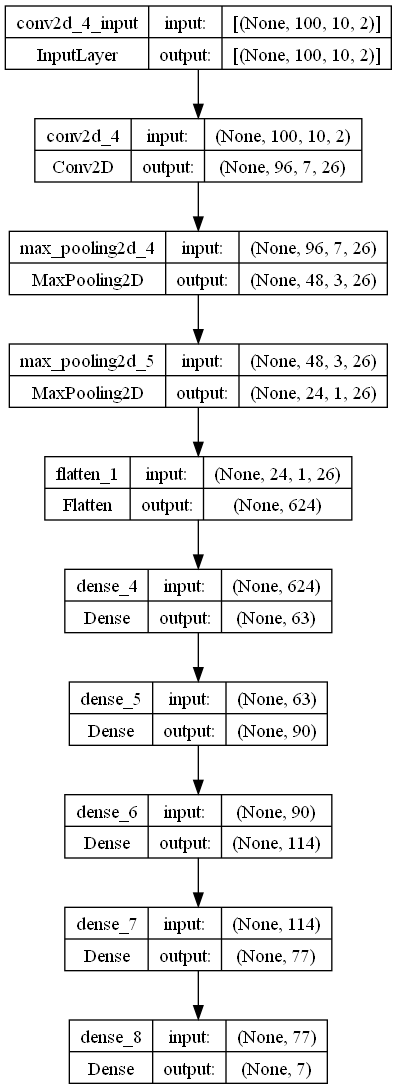

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [27]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [28]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [29]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 50
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 100,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 5s 38ms/step - loss: 7.8898 - a_1: 2.7171 - a_2: 2.6912 - b_1: 2.3339 - b_2: 2.2456 - d_1: 1.6005 - d_2: 1.5636 - n: 1.5205 - mean_metric: 0.4862 - val_loss: 6.6161 - val_a_1: 2.6746 - val_a_2: 2.6320 - val_b_1: 1.9308 - val_b_2: 1.7964 - val_d_1: 1.2849 - val_d_2: 1.2055 - val_n: 1.4625 - val_mean_metric: 0.4261 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 2s 26ms/step - loss: 6.1688 - a_1: 2.6256 - a_2: 2.6165 - b_1: 1.7518 - b_2: 1.6195 - d_1: 1.0107 - d_2: 0.9751 - n: 1.4576 - mean_metric: 0.3996 - val_loss: 5.7519 - val_a_1: 2.5998 - val_a_2: 2.6104 - val_b_1: 1.4961 - val_b_2: 1.4761 - val_d_1: 0.8209 - val_d_2: 0.8448 - val_n: 1.4364 - val_mean_metric: 0.3702 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 2s 28ms/step - loss: 5.6900 - a_1: 2.5746 - a_2: 2.5802 - b_1: 1.5352 - b_2: 1.4795 - d_1: 0.8025 - d_2: 0.7863 - n: 1.4379 - mean_metric: 0.3711 - val_loss: 5.5465 - val_a_1: 2.5613

70/70 [==============================] - 2s 25ms/step - loss: 3.7815 - a_1: 2.1547 - a_2: 2.1498 - b_1: 1.0696 - b_2: 1.0560 - d_1: 0.4030 - d_2: 0.3994 - n: 1.3329 - mean_metric: 0.2839 - val_loss: 4.2747 - val_a_1: 2.3497 - val_a_2: 2.3105 - val_b_1: 1.3223 - val_b_2: 1.1136 - val_d_1: 0.4027 - val_d_2: 0.4003 - val_n: 1.3059 - val_mean_metric: 0.3021 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 2s 23ms/step - loss: 3.7615 - a_1: 2.1572 - a_2: 2.1275 - b_1: 1.0694 - b_2: 1.0549 - d_1: 0.4005 - d_2: 0.4195 - n: 1.3340 - mean_metric: 0.2838 - val_loss: 4.1473 - val_a_1: 2.3113 - val_a_2: 2.3038 - val_b_1: 1.0912 - val_b_2: 1.1248 - val_d_1: 0.4354 - val_d_2: 0.4000 - val_n: 1.2961 - val_mean_metric: 0.2941 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 2s 25ms/step - loss: 3.7092 - a_1: 2.1410 - a_2: 2.1209 - b_1: 1.0197 - b_2: 1.0587 - d_1: 0.4010 - d_2: 0.3979 - n: 1.3321 - mean_metric: 0.2808 - val_loss: 4.1825 - val_a_1: 2.3060 - val_a_2:

70/70 [==============================] - 2s 24ms/step - loss: 3.2341 - a_1: 1.9426 - a_2: 1.9740 - b_1: 0.9856 - b_2: 0.9900 - d_1: 0.3688 - d_2: 0.3908 - n: 1.3004 - mean_metric: 0.2636 - val_loss: 3.9373 - val_a_1: 2.2210 - val_a_2: 2.2936 - val_b_1: 1.1848 - val_b_2: 1.1039 - val_d_1: 0.3734 - val_d_2: 0.4035 - val_n: 1.3004 - val_mean_metric: 0.2914 - lr: 9.6457e-04
Epoch 86/1000
70/70 [==============================] - 2s 25ms/step - loss: 3.2431 - a_1: 1.9646 - a_2: 1.9694 - b_1: 0.9931 - b_2: 0.9936 - d_1: 0.3662 - d_2: 0.3832 - n: 1.3067 - mean_metric: 0.2644 - val_loss: 3.8941 - val_a_1: 2.2523 - val_a_2: 2.2889 - val_b_1: 1.0704 - val_b_2: 1.0806 - val_d_1: 0.3549 - val_d_2: 0.4072 - val_n: 1.2901 - val_mean_metric: 0.2869 - lr: 9.6353e-04
Epoch 87/1000
70/70 [==============================] - 2s 23ms/step - loss: 3.2337 - a_1: 1.9603 - a_2: 1.9618 - b_1: 0.9830 - b_2: 0.9976 - d_1: 0.3660 - d_2: 0.3816 - n: 1.3013 - mean_metric: 0.2636 - val_loss: 3.8782 - val_a_1: 2.2492 - 

70/70 [==============================] - 2s 25ms/step - loss: 2.9519 - a_1: 1.8124 - a_2: 1.8511 - b_1: 0.9472 - b_2: 0.9634 - d_1: 0.3811 - d_2: 0.3907 - n: 1.2942 - mean_metric: 0.2532 - val_loss: 4.0175 - val_a_1: 2.2793 - val_a_2: 2.2973 - val_b_1: 1.1268 - val_b_2: 1.0957 - val_d_1: 0.3622 - val_d_2: 0.4359 - val_n: 1.2990 - val_mean_metric: 0.2919 - lr: 9.2080e-04
Epoch 128/1000
70/70 [==============================] - 2s 24ms/step - loss: 2.9037 - a_1: 1.7925 - a_2: 1.8443 - b_1: 0.9349 - b_2: 0.9444 - d_1: 0.3544 - d_2: 0.3809 - n: 1.2918 - mean_metric: 0.2500 - val_loss: 4.0120 - val_a_1: 2.2755 - val_a_2: 2.2757 - val_b_1: 1.1345 - val_b_2: 1.1099 - val_d_1: 0.4361 - val_d_2: 0.4215 - val_n: 1.2988 - val_mean_metric: 0.2938 - lr: 9.1976e-04
Epoch 129/1000
70/70 [==============================] - 2s 24ms/step - loss: 2.9117 - a_1: 1.8109 - a_2: 1.8263 - b_1: 0.9491 - b_2: 0.9390 - d_1: 0.3736 - d_2: 0.3883 - n: 1.2911 - mean_metric: 0.2512 - val_loss: 3.9567 - val_a_1: 2.2670 

70/70 [==============================] - 2s 26ms/step - loss: 2.7412 - a_1: 1.6905 - a_2: 1.7394 - b_1: 0.9381 - b_2: 0.9495 - d_1: 0.3648 - d_2: 0.3838 - n: 1.2804 - mean_metric: 0.2435 - val_loss: 4.1025 - val_a_1: 2.3211 - val_a_2: 2.3224 - val_b_1: 1.1495 - val_b_2: 1.0945 - val_d_1: 0.3566 - val_d_2: 0.4098 - val_n: 1.3074 - val_mean_metric: 0.2941 - lr: 8.7703e-04
Epoch 170/1000
70/70 [==============================] - 2s 26ms/step - loss: 2.7197 - a_1: 1.6762 - a_2: 1.7247 - b_1: 0.9376 - b_2: 0.9445 - d_1: 0.3643 - d_2: 0.3911 - n: 1.2791 - mean_metric: 0.2426 - val_loss: 4.1079 - val_a_1: 2.3090 - val_a_2: 2.3266 - val_b_1: 1.1275 - val_b_2: 1.0985 - val_d_1: 0.3681 - val_d_2: 0.4177 - val_n: 1.3022 - val_mean_metric: 0.2937 - lr: 8.7599e-04
Epoch 171/1000
70/70 [==============================] - 2s 25ms/step - loss: 2.7254 - a_1: 1.6787 - a_2: 1.7243 - b_1: 0.9457 - b_2: 0.9317 - d_1: 0.3634 - d_2: 0.3953 - n: 1.2768 - mean_metric: 0.2425 - val_loss: 4.1537 - val_a_1: 2.3237 

# Analizamos accuracy y loss

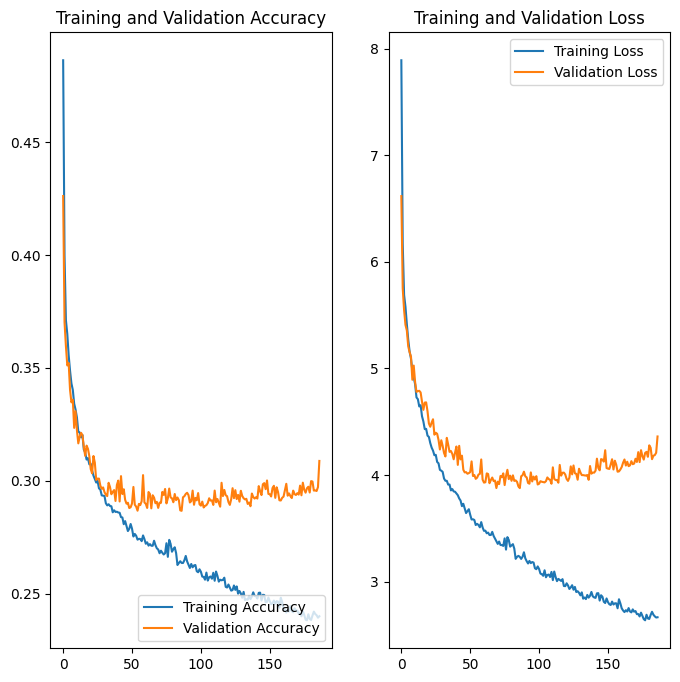

In [32]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(187)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

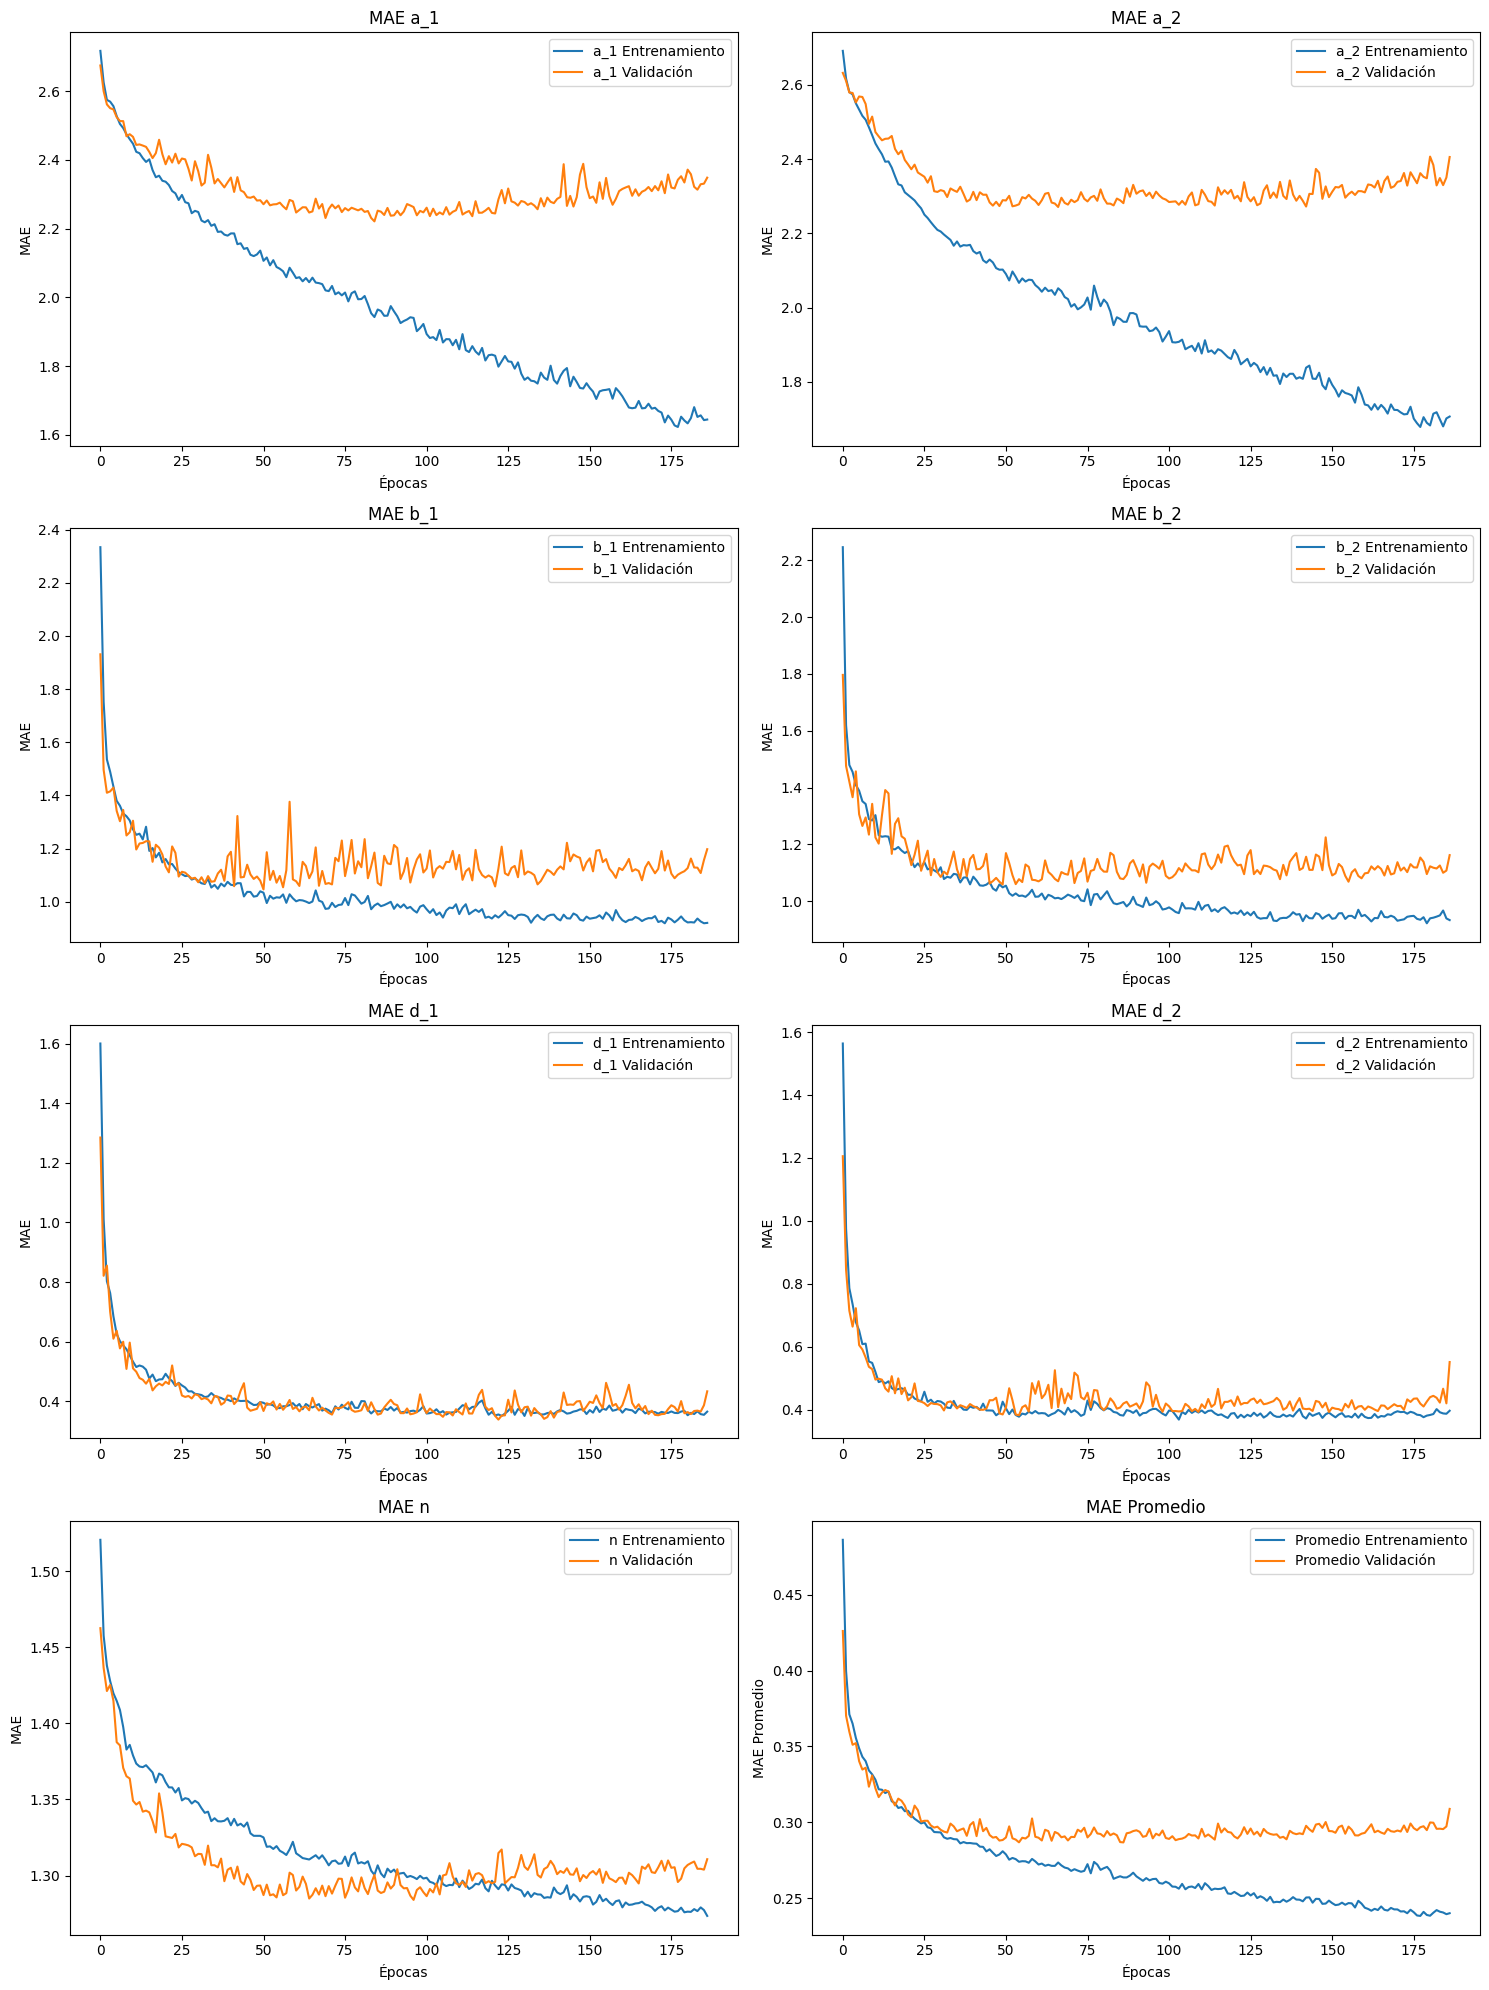

In [33]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [34]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 2s 17ms/step - loss: 3.9193 - a_1: 2.2695 - a_2: 2.2861 - b_1: 1.0864 - b_2: 1.0256 - d_1: 0.3796 - d_2: 0.3914 - n: 1.3211 - mean_metric: 0.2894


In [35]:
predictions = model.predict(varftest)

63/63 [==============================] - 1s 5ms/step


In [36]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.2514814043055686, Desviación estándar del error: 1.8047949346611103, Error absoluto máximo: 8.904981136322021


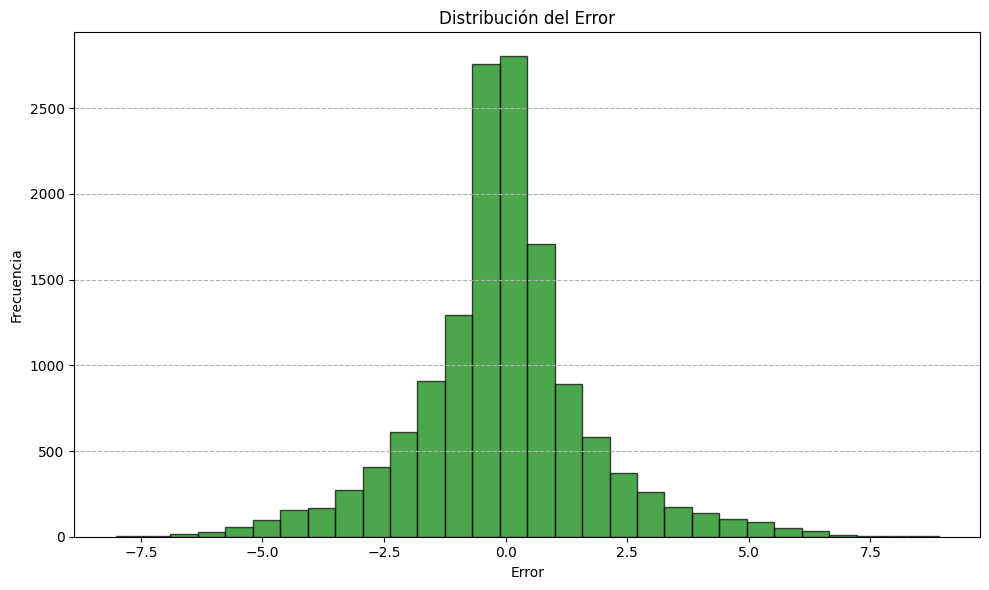

In [37]:
# Calcula el error absoluto para cada dato
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [38]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

MAE relativo: 0.2933121931934113
Desviación estándar del error relativo: 0.1738366005835322
Error absoluto máximo relativo: 1.8854244990008218


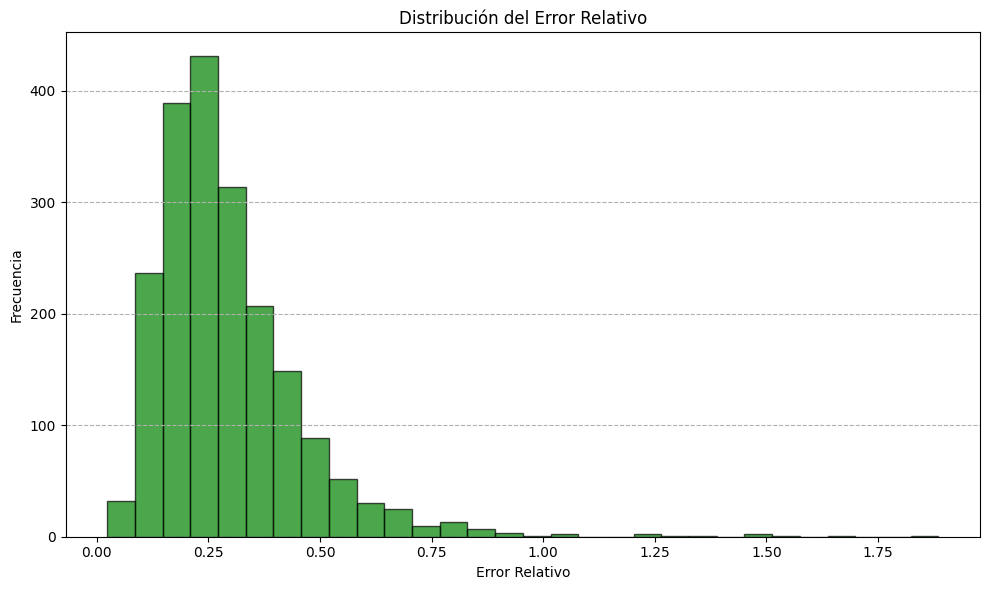

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [40]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 50,100/historyconvtrayec100.csv', index=False)

# Guardamos el modelo

In [41]:
path_to_save = '../../../Modelos con ruido/Modelos 50,100/'

In [42]:
model.save(path_to_save + '/convolucionaltr100.h5')

# Importamos el modelo

In [43]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [44]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [45]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 50,100/convolucionaltr100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [46]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[3, 5, 9, 3, 5, 2, 5]
(10, 2, 100)


In [47]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [48]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 231ms/step
[[6. 8. 7. 2. 4. 3. 3.]]


## Graficamos con los coeficientes reales

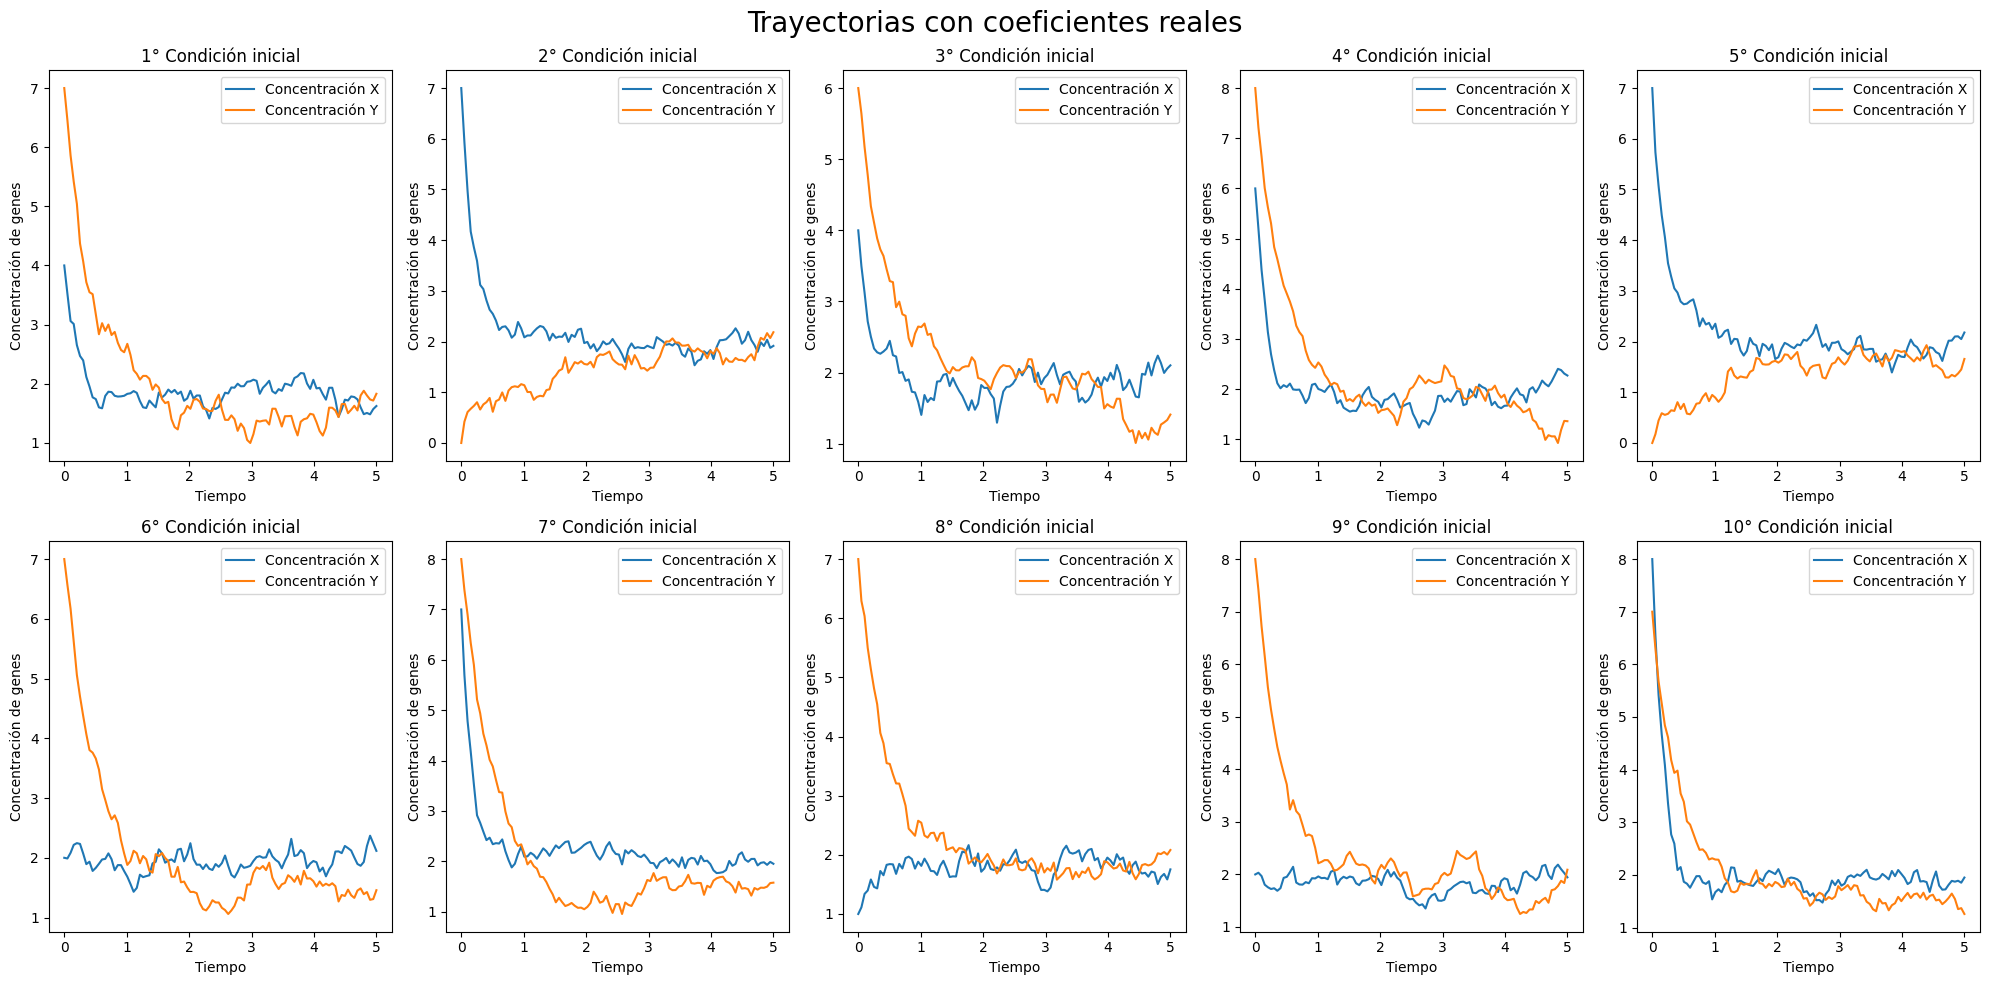

In [49]:
import matplotlib.pyplot as plt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [50]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

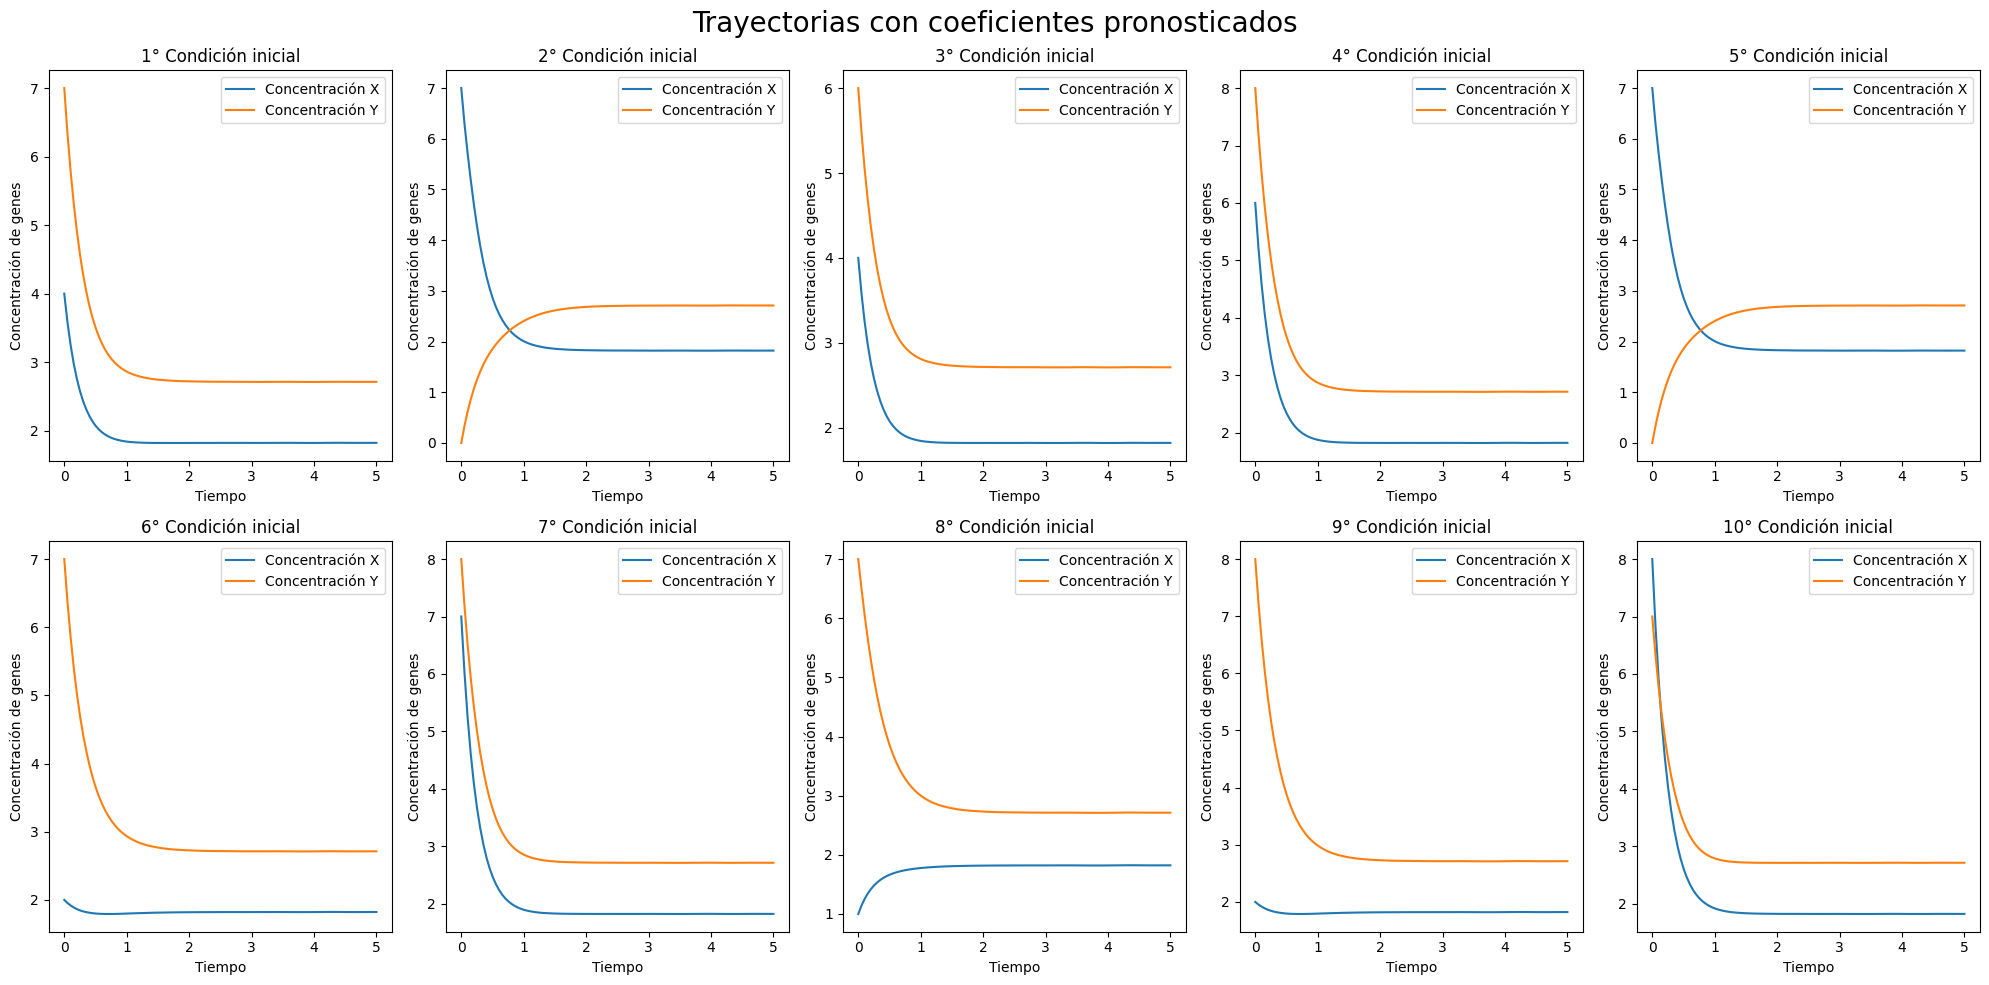

In [51]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

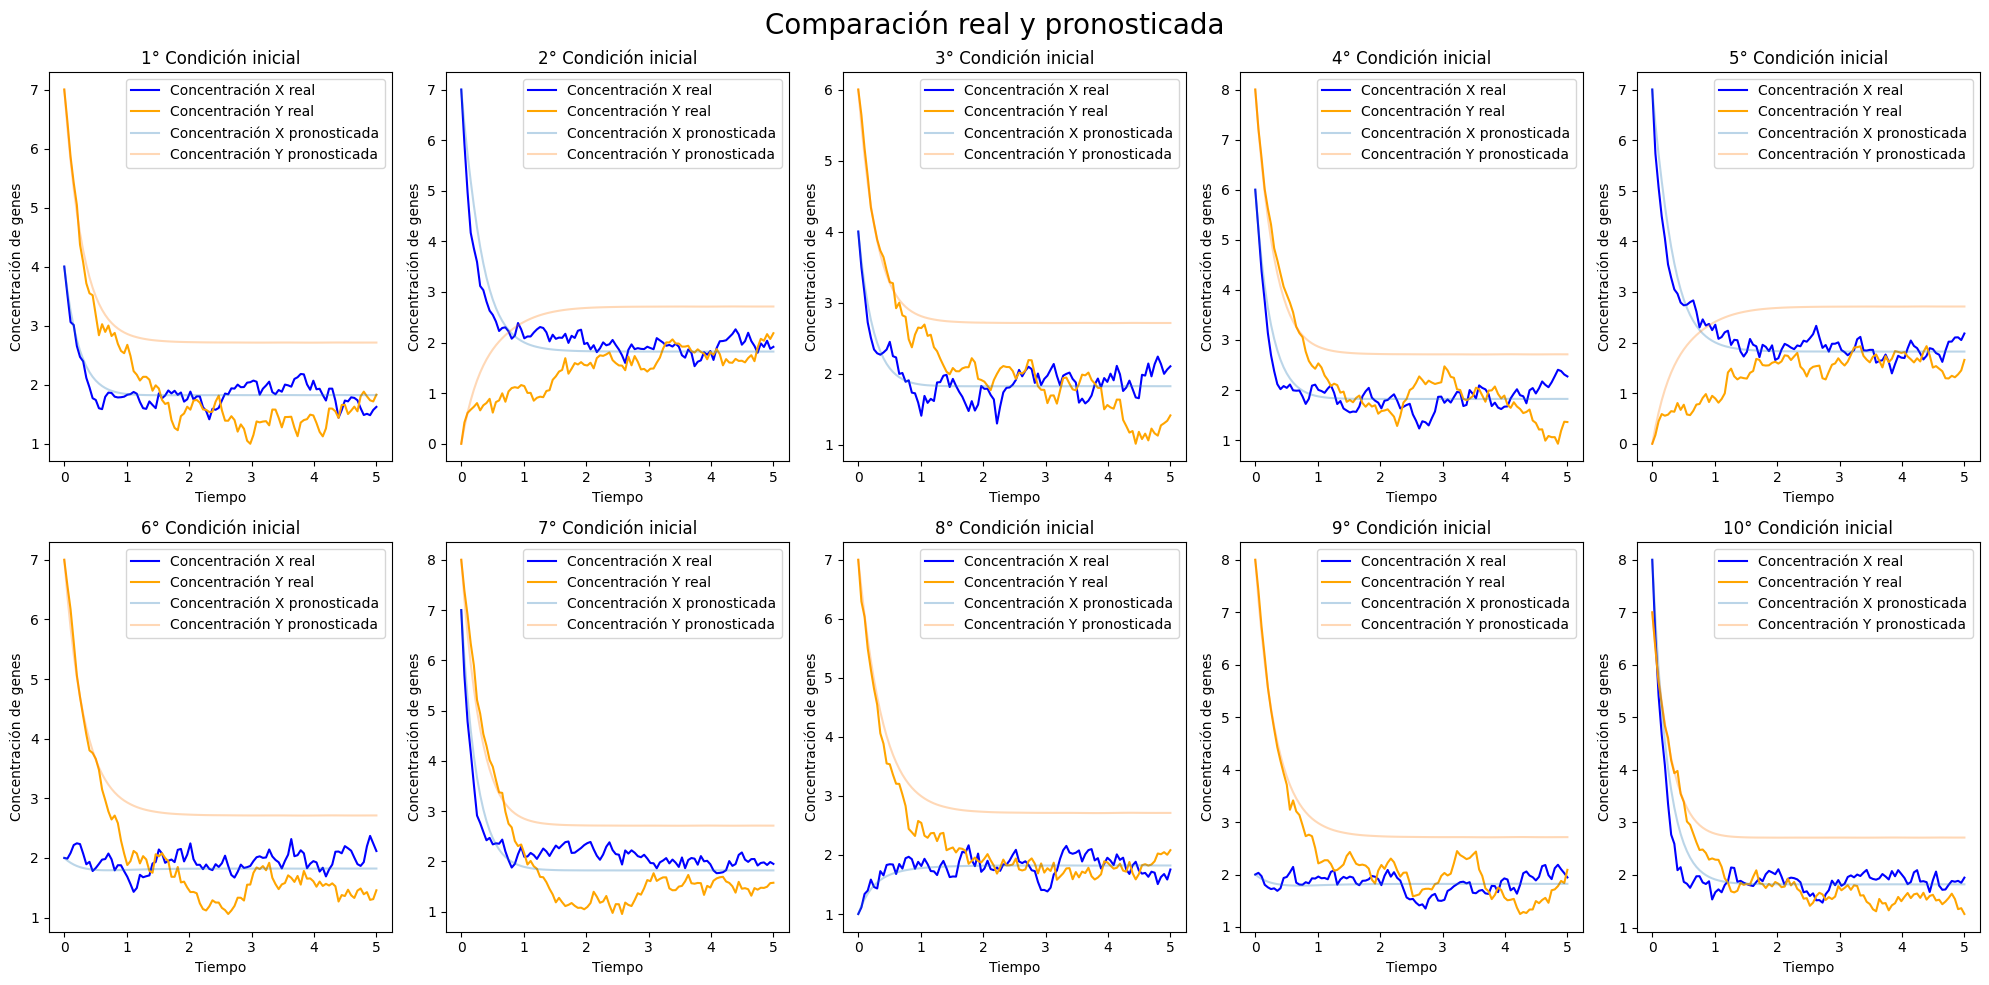

In [52]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

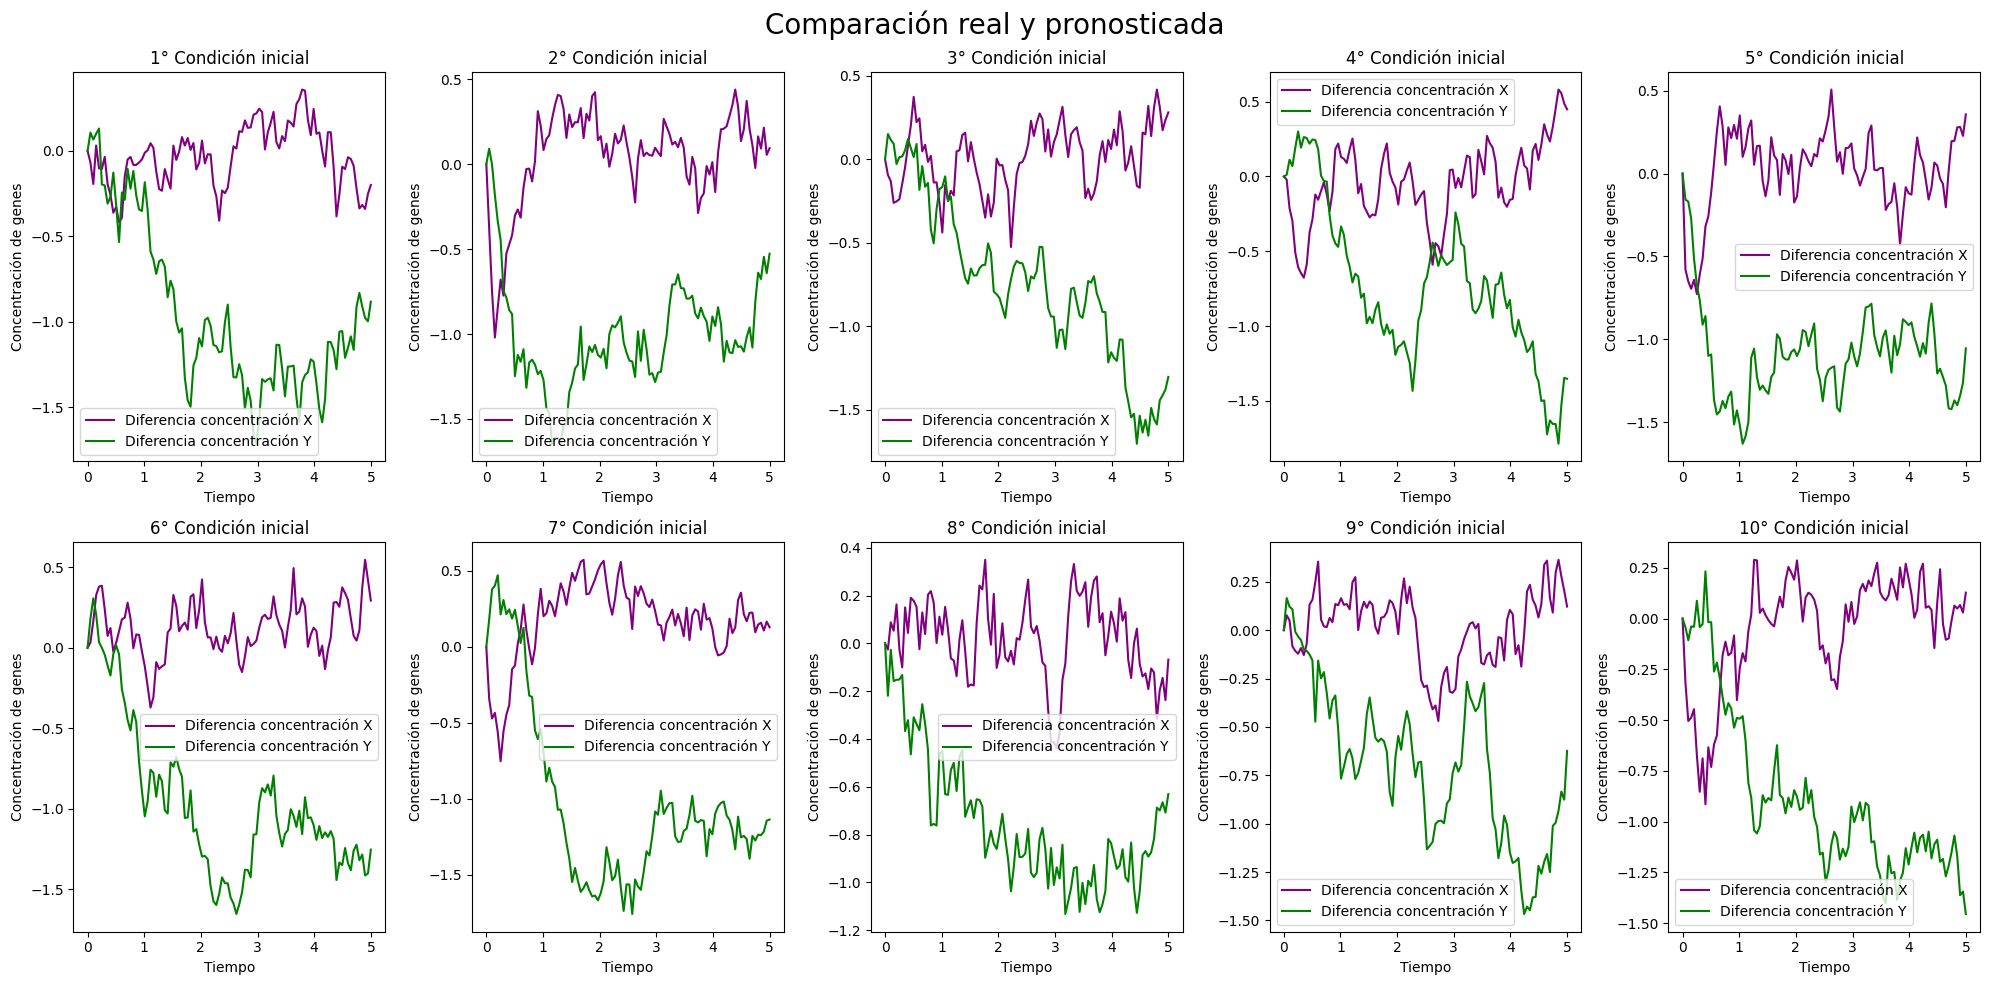

In [53]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [54]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.09071780461805735
0.4498804262340022


## Diferencias relativas

C:\Users\rafae\AppData\Local\Temp\ipykernel_6160\2855101149.py:18: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)


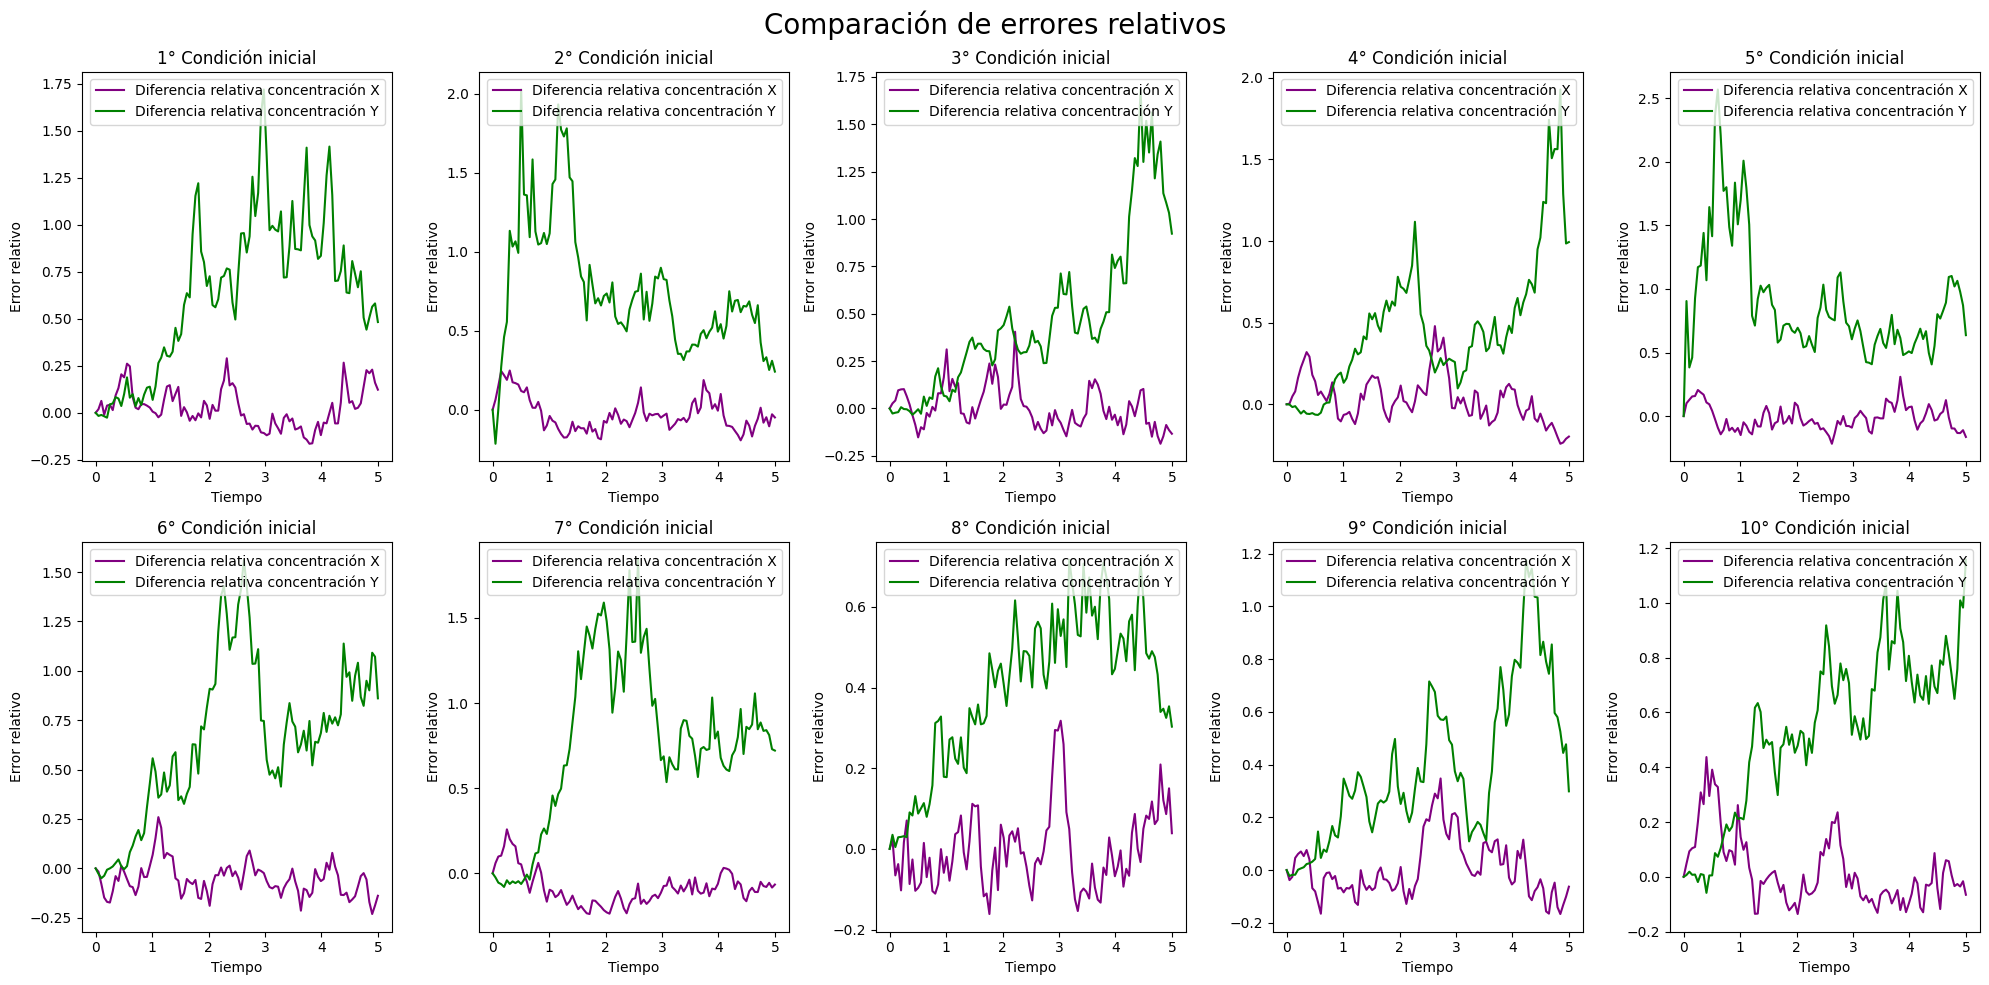

Suma mayor error relativo 97.40771288242802
Número de condición inicial 5


In [55]:
# Vamos a crear una lista para almacenar las sumas de los errores relativos para X y Y
sum_relative_errors_X = []
sum_relative_errors_Y = []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # Diferencia relativa
    # Asegurándonos de evitar divisiones por cero
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, (pred_X - real_X) / real_X, 0)
    relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)
    
    axes[i].plot(times, relative_diff_X, label=f"Diferencia relativa concentración X", alpha=1, color="purple")
    axes[i].plot(times, relative_diff_Y, label=f"Diferencia relativa concentración Y", alpha=1, color="g")
    
    # Suma de los errores relativos
    sum_relative_errors_X.append(np.sum(np.abs(relative_diff_X)))
    sum_relative_errors_Y.append(np.sum(np.abs(relative_diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Error relativo')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación de errores relativos', fontsize=20)

plt.tight_layout()
plt.show()

# Podrías encontrar el máximo error relativo de la misma forma que el error absoluto
sum_total_relative_errors = [ex + ey for ex, ey in zip(sum_relative_errors_X, sum_relative_errors_Y)]
max_relative_error = max(sum_total_relative_errors)
index_max_relative_error = sum_total_relative_errors.index(max_relative_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico

print('Suma mayor error relativo', max_relative_error)
print('Número de condición inicial',index_max_relative_error)

## Error relativo global

In [56]:
# Vamos a crear listas para almacenar el máximo error relativo y el tiempo en que ocurre para cada condición inicial
max_relative_errors_X = []
max_relative_errors_Y = []
times_max_error_X = []
times_max_error_Y = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Encontrar el valor máximo y el tiempo en el que ocurre
    max_error_X = np.max(np.abs(relative_diff_X))
    max_error_Y = np.max(np.abs(relative_diff_Y))
    time_max_error_X = times[np.argmax(relative_diff_X)]
    time_max_error_Y = times[np.argmax(relative_diff_Y)]
    
    max_relative_errors_X.append(max_error_X)
    max_relative_errors_Y.append(max_error_Y)
    times_max_error_X.append(time_max_error_X)
    times_max_error_Y.append(time_max_error_Y)

# Ahora puedes encontrar el error relativo máximo global y la condición inicial y tiempo en el que ocurre
global_max_error_X = max(max_relative_errors_X)
global_max_error_Y = max(max_relative_errors_Y)

index_global_max_error_X = max_relative_errors_X.index(global_max_error_X) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
index_global_max_error_Y = max_relative_errors_Y.index(global_max_error_Y) + 1

time_global_max_error_X = times_max_error_X[index_global_max_error_X - 1]  # Restamos 1 para ajustar el índice a la lista de Python
time_global_max_error_Y = times_max_error_Y[index_global_max_error_Y - 1]

print(f"El error relativo máximo para X es {global_max_error_X*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_X)
print("Ocurre en el tiempo:", time_global_max_error_X)

print(f"El error relativo máximo para Y es {global_max_error_Y*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_Y)
print("Ocurre en el tiempo:", time_global_max_error_Y)

El error relativo máximo para X es 47.88%
Ocurre en la condición inicial número: 4
Ocurre en el tiempo: 2.6262626262626263
El error relativo máximo para Y es 256.91%
Ocurre en la condición inicial número: 5
Ocurre en el tiempo: 0.6060606060606061


C:\Users\rafae\AppData\Local\Temp\ipykernel_6160\2700797786.py:16: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


In [57]:

# Vamos a crear una lista para almacenar el máximo error relativo combinado (X + Y) y los tiempos en los que ocurre para cada condición inicial
max_combined_relative_errors = []
times_max_combined_error = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Calculamos la suma de los errores relativos en X y Y para cada punto en el tiempo
    combined_relative_error = relative_diff_X + relative_diff_Y
    
    # Encontramos el valor máximo y el tiempo en el que ocurre
    max_combined_error = np.max(combined_relative_error)
    time_max_combined_error = times[np.argmax(combined_relative_error)]
    
    max_combined_relative_errors.append(max_combined_error)
    times_max_combined_error.append(time_max_combined_error)

# Ahora puedes encontrar el error relativo combinado máximo global y la condición inicial y tiempo en que ocurre
global_max_combined_error = max(max_combined_relative_errors)
index_global_max_combined_error = max_combined_relative_errors.index(global_max_combined_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
time_global_max_combined_error = times_max_combined_error[index_global_max_combined_error - 1]  # Restamos 1 para ajustar el índice a la lista de Python

print(f"El error relativo combinado máximo (X + Y) es {global_max_combined_error*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_combined_error)
print("Ocurre en el tiempo:", time_global_max_combined_error)

El error relativo combinado máximo (X + Y) es 266.02%
Ocurre en la condición inicial número: 5
Ocurre en el tiempo: 0.6060606060606061


C:\Users\rafae\AppData\Local\Temp\ipykernel_6160\2532752332.py:14: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


## Hacemos esto n veces

In [61]:
# Importando las librerías necesarias
import numpy as np
import random
from scipy.integrate import solve_ivp


todas_diferencias_relativas_X = []
todas_diferencias_relativas_Y = []

# Inicializar las variables para almacenar los errores relativos máximos globales y los coeficientes correspondientes
max_global_error_X = 0
max_global_error_Y = 0
coef_max_error_X = None
coef_max_error_Y = None
coef_max_error_X_pred = None
coef_max_error_Y_pred = None
condinimaxX = None
condinimaxY = None

condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

# Realizamos 10 iteraciones
for iteration in range(100):
    condini = []
    varf = []
    coef = []
    # constantes
    a1 = random.randint(1, 10)
    a2 = random.randint(1, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(1, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def ftrue(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(ftrue, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfcitrue = np.append([var1], [var2], axis=0)
        varfci2.append(varfcitrue)    

    varftrue= varfci2
    varftrue = np.array(varftrue)
    print(coef)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)
    
    varf= varfci2
    varf = np.array(varf)

    
    varfnone = varf[None, :]
    varfnone = np.transpose(varfnone, (0,3,1,2))  
    new_predictions = new_model.predict(varfnone)
    new_predictions = np.round(new_predictions)
    print(new_predictions)  

    a1pred = new_predictions[0,0]
    a2pred = new_predictions[0,1]
    b1pred = new_predictions[0,2]
    b2pred = new_predictions[0,3]
    d1pred = new_predictions[0,4]
    d2pred = new_predictions[0,5]
    npred = new_predictions[0,6]
    
    # Verificar si a1pred, a2pred, o npred son iguales a cero
    if a1pred == 0 or a2pred == 0 or npred == 0:
        print("Uno de los coeficientes críticos es cero, saltando esta iteración.")
        continue  # Salta al inicio del bucle for para la próxima iteración

    varfpred = []

    def f_pred(t, y):
        X = y[0]
        Y = y[1]
        dX_dt = a1pred / (1 + Y ** npred) - d1pred * X + b1pred
        dY_dt = a2pred / (1 + X ** npred) - d2pred * Y + b2pred
        return [dX_dt, dY_dt]

    varfci2pred = []
    for i_ci in range(10):
        y0 = condini[i_ci]
        sol = solve_ivp(f_pred, t_span, y0, t_eval=times)
        var1pred = sol.y[0]
        var2pred = sol.y[1]
        varfcipred = np.append([var1pred], [var2pred], axis=0)
        varfci2pred.append(varfcipred)
    varfpred = varfci2pred

    # Inicializar listas para almacenar los errores relativos máximos y medios para todas las iteraciones
    todos_errores_maximos_X = []
    todos_errores_maximos_Y = []
    todos_errores_medios_X = []
    todos_errores_medios_Y = []
    
   # Calcular las diferencias relativas para cada conjunto de condiciones iniciales
    for i in range(10):  # Asumiendo que hay 10 condiciones iniciales
        real_X = np.array(varftrue)[i, 0, :]
        real_Y = np.array(varftrue)[i, 1, :]
        pred_X = np.array(varfpred)[i, 0, :]
        pred_Y = np.array(varfpred)[i, 1, :]
        
        # Calcular las diferencias relativas donde los valores reales no son cero
        diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
        diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
        
        # Excluir los valores mayores a 100
        diferencia_relativa_X = np.extract(diferencia_relativa_X <= 1, diferencia_relativa_X)
        diferencia_relativa_Y = np.extract(diferencia_relativa_Y <= 1, diferencia_relativa_Y)
        
        # Agregar estas diferencias a la lista total
        todas_diferencias_relativas_X.extend(diferencia_relativa_X)
        todas_diferencias_relativas_Y.extend(diferencia_relativa_Y)
        
        # Calcular el error relativo máximo en esta iteración y condición inicial
        max_error_iter_X = np.max(diferencia_relativa_X)
        max_error_iter_Y = np.max(diferencia_relativa_Y)
        
        # Comprobar si estos son nuevos máximos globales
        if max_error_iter_X > max_global_error_X:
            max_global_error_X = max_error_iter_X
            coef_max_error_X = coef  # Coeficientes reales
            coef_max_error_X_pred = new_predictions  # Coeficientes predichos
            condinimaxX = condini
            
        if max_error_iter_Y > max_global_error_Y:
            max_global_error_Y = max_error_iter_Y
            coef_max_error_Y = coef  # Coeficientes reales
            coef_max_error_Y_pred = new_predictions  # Coeficientes predichos
            condinimaxY = condini


# Convertir las listas a arreglos NumPy para facilitar los cálculos
todas_diferencias_relativas_X = np.array(todas_diferencias_relativas_X)
todas_diferencias_relativas_Y = np.array(todas_diferencias_relativas_Y)

# Calcular e imprimir los errores relativos medios y máximos globales
print(f"Error relativo medio global para X: {np.mean(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo medio global para Y: {np.mean(todas_diferencias_relativas_Y) * 100:.2f}%")
print(f"Error relativo máximo global para X: {np.max(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo máximo global para Y: {np.max(todas_diferencias_relativas_Y) * 100:.2f}%")

print(f"Coeficientes reales correspondientes para error máximo X: {coef_max_error_X}")
print(f"Coeficientes predichos correspondientes para error máximo X: {coef_max_error_X_pred}")


print(f"Coeficientes reales correspondientes para Y: {coef_max_error_Y}")
print(f"Coeficientes predichos correspondientes para Y: {coef_max_error_Y_pred}")


[[5, 6, 9, 7, 0, 1, 5]]
1/1 [==============================] - 0s 35ms/step
[[4. 5. 8. 9. 0. 2. 2.]]
[[10, 5, 8, 3, 10, 0, 2]]
1/1 [==============================] - 0s 52ms/step
[[7. 5. 8. 2. 8. 0. 3.]]
[[1, 6, 9, 5, 1, 4, 2]]


C:\Users\rafae\AppData\Local\Temp\ipykernel_6160\487350453.py:160: RuntimeWarning: invalid value encountered in divide
  diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_6160\487350453.py:161: RuntimeWarning: invalid value encountered in divide
  diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


1/1 [==============================] - 0s 41ms/step
[[4. 5. 8. 3. 1. 4. 3.]]
[[3, 7, 4, 0, 0, 6, 5]]
1/1 [==============================] - 0s 57ms/step
[[5. 6. 2. 1. 0. 7. 3.]]
[[9, 6, 5, 6, 9, 6, 2]]
1/1 [==============================] - 0s 27ms/step
[[5. 7. 8. 6. 9. 6. 3.]]
[[7, 10, 9, 8, 3, 10, 4]]
1/1 [==============================] - 0s 60ms/step
[[ 9.  6. 10.  7.  3.  9.  3.]]
[[9, 6, 5, 2, 8, 1, 1]]
1/1 [==============================] - 0s 58ms/step
[[5. 4. 7. 2. 8. 1. 2.]]
[[5, 4, 8, 0, 4, 1, 4]]
1/1 [==============================] - 0s 43ms/step
[[4. 3. 8. 0. 4. 1. 3.]]
[[5, 2, 6, 4, 1, 4, 1]]
1/1 [==============================] - 0s 37ms/step
[[8. 6. 9. 3. 2. 4. 3.]]
[[3, 1, 10, 7, 10, 3, 5]]
1/1 [==============================] - 0s 62ms/step
[[5. 5. 8. 6. 9. 3. 2.]]
[[3, 10, 7, 2, 1, 9, 5]]
1/1 [==============================] - 0s 27ms/step
[[5. 5. 7. 1. 1. 9. 3.]]
[[4, 5, 5, 5, 5, 7, 4]]
1/1 [==============================] - 0s 52ms/step
[[5. 4. 5. 5. 5. 7. 3.]]
[[

1/1 [==============================] - 0s 41ms/step
[[9. 1. 3. 7. 4. 9. 4.]]
[[2, 2, 7, 4, 1, 8, 3]]
1/1 [==============================] - 0s 46ms/step
[[6. 4. 7. 3. 1. 7. 3.]]
[[8, 6, 2, 6, 0, 9, 1]]
1/1 [==============================] - 0s 36ms/step
[[5. 6. 4. 6. 0. 9. 3.]]
[[4, 5, 7, 6, 0, 1, 1]]
1/1 [==============================] - 0s 63ms/step
[[6. 4. 7. 9. 0. 1. 2.]]
[[5, 9, 9, 7, 3, 2, 3]]
1/1 [==============================] - 0s 48ms/step
[[6. 5. 8. 8. 3. 2. 2.]]
[[8, 3, 1, 9, 8, 7, 4]]
1/1 [==============================] - 0s 37ms/step
[[6. 3. 1. 9. 8. 7. 3.]]
[[8, 6, 10, 10, 7, 3, 2]]
1/1 [==============================] - 0s 30ms/step
[[5. 6. 9. 9. 7. 3. 1.]]
[[4, 2, 7, 8, 0, 5, 3]]
1/1 [==============================] - 0s 60ms/step
[[5. 6. 6. 7. 0. 5. 3.]]
[[7, 4, 2, 0, 1, 7, 2]]
1/1 [==============================] - 0s 44ms/step
[[7. 5. 6. 0. 1. 8. 4.]]
[[9, 4, 10, 6, 9, 3, 1]]
1/1 [==============================] - 0s 55ms/step
[[ 8.  4. 10.  7.  9.  3.  2.]]
[[5,